# Analysis of Chemicals in Cosmetic Products
# Forecasting
___

This notebook is based on the tutorial [Time Series Forecast Study with Python: Monthly Sales of French Champagne](https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/).

## 1. Load data and Creation of Validation Dataset

#### Import libraries

In [1]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

import os
import sys
import numpy    as np
import pandas   as pd
import datetime
import warnings

from matplotlib                   import pyplot
from dateutil.relativedelta       import relativedelta
from statsmodels.tsa.arima_model  import ARIMA
from sklearn.metrics              import mean_squared_error
from math                         import sqrt
from IPython.display              import Image

# Use Plotly for statistics graphics
import plotly.plotly         as py
import plotly.graph_objs     as go
import plotly.offline        as offline
import plotly.io             as pio

# Set notebook mode = True
offline.init_notebook_mode(connected=True)

rcParams['figure.figsize'] = 15, 6

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


#### Declare constants 

In [2]:
# Variables with the names of each column in data
CDPHID_COLUMN                 = 'CDPHId'
PRODUCTNAME_COLUMN            = 'ProductName'
CSFID_COLUMN                  = 'CSFId'
CSF_COLUMN                    = 'CSF'
COMPANYID_COLUMN              = 'CompanyId'
COMPANYNAME_COLUMN            = 'CompanyName'
BRANDNAME_COLUMN              = 'BrandName'
PRIMARYCATEGORYID_COLUMN      = 'PrimaryCategoryId'
PRIMARYCATEGORY_COLUMN        = 'PrimaryCategory'
SUBCATEGORYID_COLUMN          = 'SubCategoryId'
SUBCATEGORY_COLUMN            = 'SubCategory'
CASID_COLUMN                  = 'CasId'
CASNUMBER_COLUMN              = 'CasNumber'
CHEMICALID_COLUMN             = 'ChemicalId'
CHEMICALNAME_COLUMN           = 'ChemicalName'
INITIALDATEREPORTED_COLUMN    = 'InitialDateReported'
MOSTRECENTDATEREPORTED_COLUMN = 'MostRecentDateReported'
DISCONTINUEDDATE_COLUMN       = 'DiscontinuedDate'
CHEMICALCREATEDAT_COLUMN      = 'ChemicalCreatedAt'
CHEMICALUPDATEDAT_COLUMN      = 'ChemicalUpdatedAt'
CHEMICALDATEREMOVED_COLUMN    = 'ChemicalDateRemoved'
CHEMICALCOUNT_COLUMN          = 'ChemicalCount'

# Number to replace empty value in CSFId column
CSFID_EMPTY_NUMBER  = -1
# Date value which means NaT 
NAT_DATE            = datetime.date(1900,1,1)

# List of columns which contains a Names
list_names = [ PRODUCTNAME_COLUMN, CSF_COLUMN, COMPANYNAME_COLUMN, BRANDNAME_COLUMN, 
               PRIMARYCATEGORY_COLUMN, SUBCATEGORY_COLUMN, CHEMICALNAME_COLUMN ]

# List of columns which contains a Dates
list_dates = [ INITIALDATEREPORTED_COLUMN, MOSTRECENTDATEREPORTED_COLUMN, DISCONTINUEDDATE_COLUMN,
               CHEMICALCREATEDAT_COLUMN, CHEMICALUPDATEDAT_COLUMN, CHEMICALDATEREMOVED_COLUMN ]

# Other columns
list_ids   = [ CDPHID_COLUMN, CSFID_COLUMN, COMPANYID_COLUMN, PRIMARYCATEGORYID_COLUMN, 
               SUBCATEGORYID_COLUMN, CASID_COLUMN, CHEMICALID_COLUMN ]

# Path to save the images
IMAGES_PATH   = 'img'

# Format of images
IMAGES_FORMAT = '.png'

# Path where is the dataset
DATA_PATH = 'data'

# Path where is the backup dataset
DATA_BACKUP_PATH = 'data_backup'

# File name of dataset
DATA_NAME = 'cscpopendata.csv'

# Number of previous months for create the validation dataset
PREVIOUS_MONTHS = 5

# Function to get completed path to an image
def get_path(name) :
    global IMAGES_PATH, IMAGES_FORMAT
    
    return os.path.join(IMAGES_PATH, name + IMAGES_FORMAT)

---

### 1.1. Load data

#### From data/ folder 

In [3]:
# Load data from data/ folder
data = pd.read_csv(os.path.join(DATA_PATH, DATA_NAME), sep = ',', parse_dates = list_dates)

# pd.isna() --> for NaN
# <value> is pd.NaT --> for NaT

# Fill NaT with 01/01/1900
for date_column in list_dates :
    data[date_column] = data[date_column].apply(lambda x: NAT_DATE if x is pd.NaT else x)
    

# Fill NA with ''
data = data.fillna('')

# Fill CSFId empty with -1
data[CSFID_COLUMN] = data[CSFID_COLUMN].apply(lambda x: x if x != "" else CSFID_EMPTY_NUMBER)

# Remove all rows that have a cosmetic product discontinued
data = data[data[DISCONTINUEDDATE_COLUMN].apply(lambda x: x.year) == NAT_DATE.year]

# Remove all rows that have a chemical removed
data = data[data[CHEMICALDATEREMOVED_COLUMN].apply(lambda x: x.year) == NAT_DATE.year]

# Group by InitialDateReported and sum ChemicalCount
data = pd.DataFrame(data.groupby(INITIALDATEREPORTED_COLUMN)
                    .agg({CHEMICALCOUNT_COLUMN : 'sum'}))

#### From data_backup/ folder 

In [4]:
# Load data from data_backup/ folder
data_backup = pd.read_csv(os.path.join(DATA_BACKUP_PATH, DATA_NAME), sep = ',', parse_dates = list_dates)

---

### 1.2. Creation of Validation Dataset

As the dataset is updated frequently, we are going to use it to create a validation dataset with the new data. We storage two data version: 

- The last data version in `data/` folder.
- The previous data version in `data_backup/` folder.

With that, we are going to split data as following:

- `dataset` variable will be the dataset with we are going to fit the model. This dataset will contain all data until the 5 previous months from the last month of `data_backup`. Meaning, if the last month is 02/19 (Feb, 2019), this dataset will be contain all data until the month 09/18 (Sept, 2018): the last date in dataset will be 31/08/18 (Aug 31, 2018).
- `validation` variable will be the dataset with we are going to validate the model. This dataset will contain the rest of data.

Let's create both datasets:

In [5]:
# Get the max InitialDateReported from data
data_max = max(data.index)

# Get the max InitialDateReported from data_backup
data_backup_max = max(data_backup[INITIALDATEREPORTED_COLUMN])

print('data        | Max InitialDateReported = ', data_max)
print('data_backup | Max InitialDateReported = ', data_backup_max)

data        | Max InitialDateReported =  2019-02-21 00:00:00
data_backup | Max InitialDateReported =  2019-02-06 00:00:00


In [6]:
# Set the dataset_limit
dataset_limit = datetime.datetime(data_backup_max.year, data_backup_max.month, 1) - relativedelta(months=PREVIOUS_MONTHS)

print('Current month =', datetime.datetime(data_backup_max.year, data_backup_max.month, 1))
print('Dataset limit =', dataset_limit)

Current month = 2019-02-01 00:00:00
Dataset limit = 2018-09-01 00:00:00


In [7]:
# Set the datasets with the dataset_limit
dataset = data[data.index < dataset_limit]
validation = data[data.index >= dataset_limit]

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

Len(dataset) = 1749
Len(validation) = 114


Our current datetime data can be tricky to work with, therefore, we will use the averages daily chemical count for that month instead, and we are using the start of each month as the timestamp.

In [8]:
dataset.head()

,ChemicalCount
InitialDateReported,
2009-07-01,4
2009-07-09,1
2009-07-13,6
2009-07-14,18
2009-08-10,4


In [9]:
dataset = dataset.resample('MS').mean().dropna()
validation = validation.resample('MS').mean().dropna()

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))
dataset.head()

Len(dataset) = 110
Len(validation) = 6


,ChemicalCount
InitialDateReported,
2009-07-01,7.250000
2009-08-01,31.909091
2009-09-01,237.416667
2009-10-01,779.080000
2009-11-01,46.750000


---

## 2. Grid Search ARIMA Hyperparameters 

#### Functions definition 

In [10]:
def evaluate_arima_model(X, arima_order):
    """
    Evaluate an ARIMA model for a given order (p,d,q) and return its RMSE.
    
    Params:
    X -- Timeserie which fit the ARIMA model.
    arima_order -- Order of ARIMA model.
    
    Returns:
    model -- ARIMA model.
    rmse -- RMSE of evaluation.
    train -- Train dataset.
    test -- Test dataset.
    predictions -- Predictions of ARIMA model.
    """
    
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):  
        history.append(test[t])
        # Make and fit model
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        # Prediction
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return model, rmse, train, test, predictions

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    """
    Evaluate combinations of p, d and q values for an ARIMA model.
    
    Params:
    dataset -- dataset which to fit ARIMA model.
    p_values -- values of p.
    d_values -- values of d.
    q_values -- values of q.
    
    """
    
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    _, mse, _, _, _ = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

---

#### Search hyperparameters 

We will search all combinations of the following parameters:

- p: 0 to 3.
- d: 0 to 2.
- q: 0 to 3.

This is (4 * 3 * 4), or 48, potential runs of the test harness.

In [11]:
# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
best_cfg = evaluate_models(dataset.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=42.489
ARIMA(0, 0, 2) RMSE=37.658
ARIMA(0, 0, 3) RMSE=33.792
ARIMA(0, 1, 1) RMSE=31.227
ARIMA(0, 1, 2) RMSE=28.174
ARIMA(0, 1, 3) RMSE=27.218
ARIMA(1, 0, 0) RMSE=32.862
ARIMA(1, 0, 1) RMSE=31.927
ARIMA(1, 0, 2) RMSE=28.848
ARIMA(1, 1, 0) RMSE=18.822
ARIMA(1, 1, 1) RMSE=26.913
ARIMA(1, 1, 2) RMSE=26.834
ARIMA(2, 0, 0) RMSE=31.312
ARIMA(2, 1, 0) RMSE=20.130
ARIMA(3, 0, 0) RMSE=31.043
ARIMA(3, 1, 0) RMSE=27.813
Best ARIMA(1, 1, 0) RMSE=18.822


We will select this ARIMA(1, 1, 0) model going forward.

---

## 3. Review Residual Errors

A good final check of a model is to review residual forecast errors.

Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

We can check this by using summary statistics and plots to investigate the residual errors from the ARIMA(1, 1, 0) model. Let's calculate and summarize the residual forecast errors:

In [12]:
best_cfg

(1, 1, 0)

               0
count  28.000000
mean    1.458268
std    19.109321
min   -47.027313
25%    -6.768431
50%     0.998731
75%     6.915119
max    55.509043


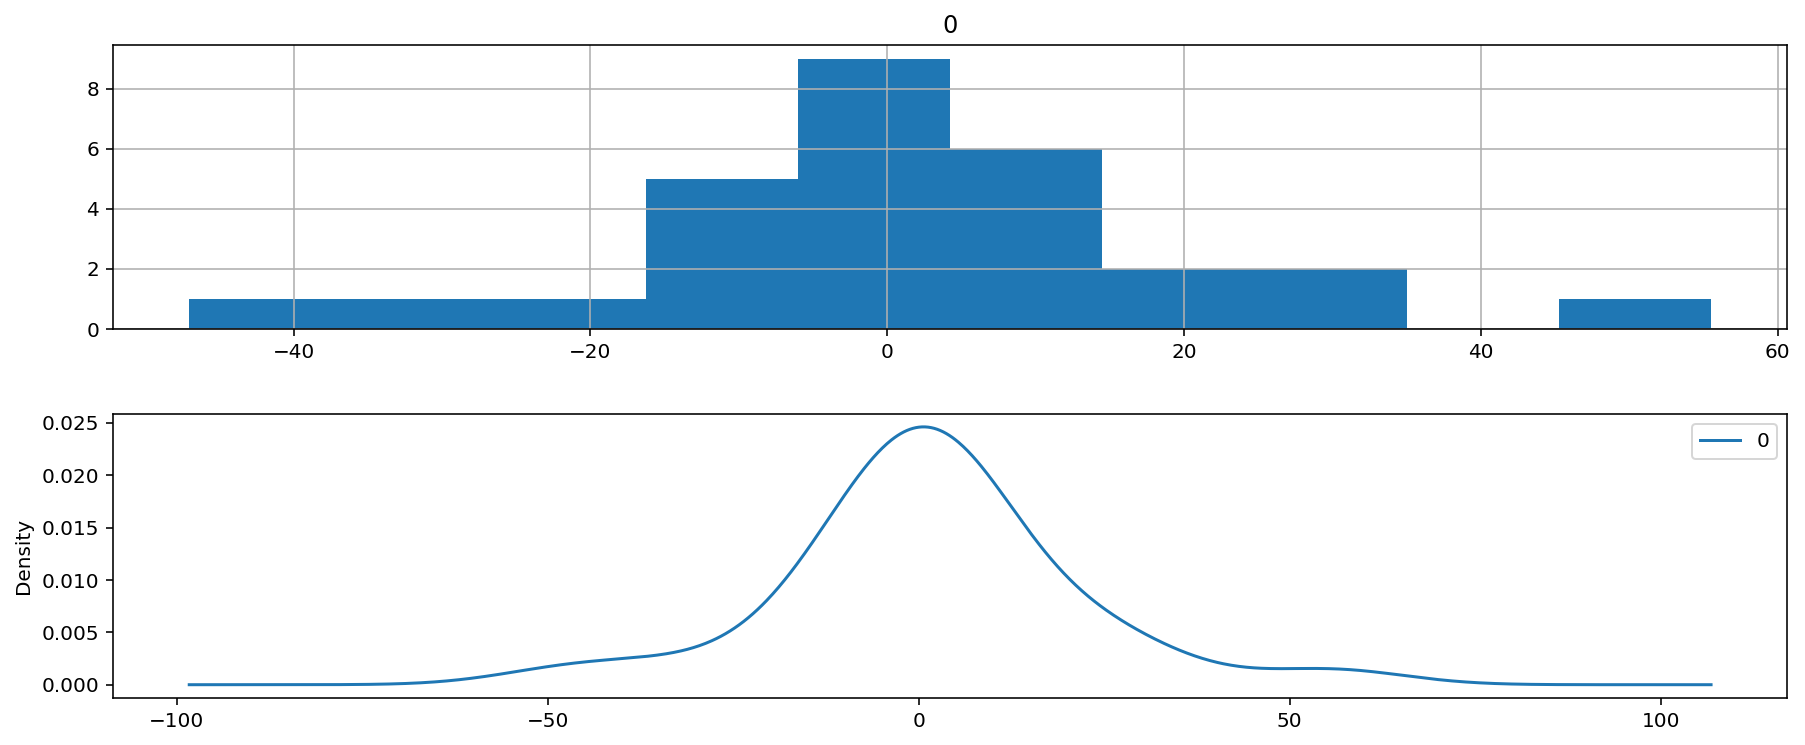

In [13]:
_, _, train, test, predictions = evaluate_arima_model(dataset.values, best_cfg)

# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

The summary of the forecast residual errors shows that the mean was indeed moved to a value very close to zero. So, the predictions are not biased.

---

## 4. Model Validation 

### 4.1. Finalize Model 

In [14]:
# prepare data
X = dataset.values
X = X.astype('float32')

# fit model
model = ARIMA(dataset.values, order=best_cfg)
model_fit = model.fit(trend='nc', disp=0)

### 4.2. Make Prediction 

In [15]:
yhat = float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 106.327


In [16]:
validation[CHEMICALCOUNT_COLUMN][0]

91.3125

In [17]:
# prepare datasets
X = dataset.values.astype('float32')
history = [x for x in X]
y = validation.values.astype('float32')
history.append(y[0])

# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
predictions.append(yhat)
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
    # observation
    obs = y[i]
    history.append(obs)
    
    # predict
    model = ARIMA(history, order=best_cfg)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = float(model_fit.forecast()[0])
    predictions.append(yhat)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    

>Predicted=106.327, Expected= 91
>Predicted=53.519, Expected= 24
>Predicted=23.437, Expected= 23
>Predicted=35.555, Expected= 45
>Predicted=63.225, Expected= 77
>Predicted=74.358, Expected= 72


In [18]:
# Plot results
def plot_results(validation, predictions, title, filename):
    data_plot = [
        go.Scatter(
            x = validation.index,
            y = validation[CHEMICALCOUNT_COLUMN],
            name = 'Real values',
            line = dict(color = '#17BECF'),
            opacity = 0.8
        ),

        go.Scatter(
            x = validation.index,
            y = predictions,
            name = 'Predictions',
            line = dict(color = '#7F7F7F'),
            opacity = 0.8
        )
    ]

    layout = go.Layout(
        title=title,
        xaxis=dict(
            title='Initial Date Reported'
        ),
        yaxis=dict(
            title='Chemical Count'
        ),
        plot_bgcolor='rgba(240,240,240, 0.95)'
    )

    fig = go.Figure(data=data_plot, layout=layout)
    offline.iplot(fig)
    pio.write_image(fig, get_path(filename))
    return get_path(filename)

RMSE: 15.212


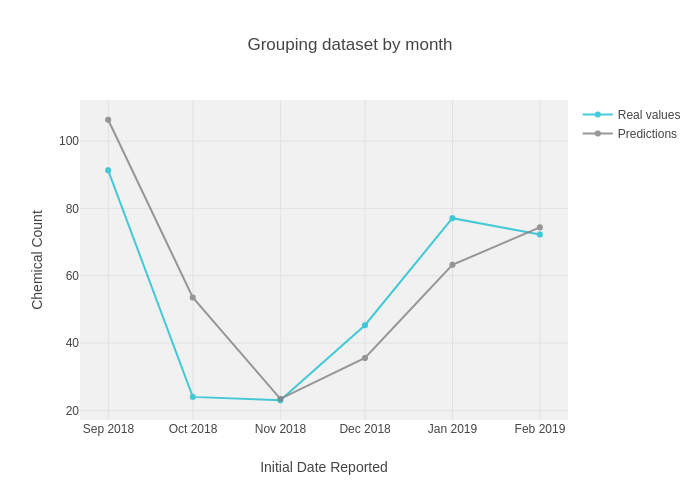

In [19]:
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

img = plot_results(validation, predictions, 'Grouping dataset by month', 'ts-grouping-by-month')
Image(img)

As we can see, the model has a small RMSE and we can say that the model is correct. Also, we have only fitted the model using the aggregated data by month and this dataset is small. Now, let's fit the model grouping by:

- Each 15 days.
- Each 7 days.
- All dataset.

---

## 5. Testing with several dataset groupings

#### Functions definition 

In [20]:
def forecasting(X, y, best_cfg, bias = 0.0, title = 'Validation Forecasting', verbose = True) :
    """
    Make the forecasting fitting ARIMA model with 'X' dataset and comparing with 'y' dataset. 

    Params:
    X -- dataset which to fit ARIMA model.
    y -- dataset whict to validate the model.
    best_cfg -- best configuration of the order (p,d,q).
    
    Returns:
    predictions -- Predictions made from the model.
    """
    
    history = [x for x in X]
    history.append(y[0])
    
    # fit model
    model = ARIMA(history, order=best_cfg)
    model_fit = model.fit(trend='nc', disp=0)
    
    # make first prediction
    predictions = list()
    yhat = bias + float(model_fit.forecast()[0])
    predictions.append(yhat)
    if verbose : 
        print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

    # rolling forecasts
    for i in range(1, len(y)):
        # observation
        obs = y[i]
        history.append(obs)
        
        # predict
        model = ARIMA(history, order=best_cfg)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = bias + float(model_fit.forecast()[0])
        predictions.append(yhat)
        if verbose : 
            print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

    # report performance
    mse = mean_squared_error(y, predictions)
    rmse = sqrt(mse)
    print('RMSE: %.3f' % rmse)
    
    return predictions
    

def all_process(dataset, validation, title, filename) :
    """
    Make all process: from the model's evaluation for getting the 
    best_cfg to make the forecasting with the validation dataset.
    
    Params:
    dataset -- dataset which to fit ARIMA model.
    validation -- dataset whict to validate the model.
    title -- title of plots.
    
    Returns:
    None.
    """
    # prepare data
    X = dataset.values
    X = X.astype('float32')
    y = validation.values.astype('float32')

    # evaluate parameters
    p_values = range(0, 4)
    d_values = range(0, 2)
    q_values = range(0, 4)
    warnings.filterwarnings("ignore")
    best_cfg = evaluate_models(dataset.values, p_values, d_values, q_values)

    model, rmse, train, test, predictions = evaluate_arima_model(dataset.values, best_cfg)

    # errors
    residuals = [test[i]-predictions[i] for i in range(len(test))]
    residuals = pd.DataFrame(residuals)
    print(residuals.describe())
    # plot
    pyplot.figure()
    pyplot.subplot(211)
    residuals.hist(ax=pyplot.gca())
    pyplot.subplot(212)
    residuals.plot(kind='kde', ax=pyplot.gca())
    pyplot.show()

    forecasting_predictions = forecasting(X, y, best_cfg, title = title)
    
    img = plot_results(validation, forecasting_predictions, title, filename)
    return img

---

### 5.1. Grouping dataset by each 15 days

Len(dataset) = 1749
Len(validation) = 114
Len(dataset) = 223
Len(validation) = 12
ARIMA(0, 0, 1) RMSE=43.776
ARIMA(0, 0, 2) RMSE=34.693
ARIMA(0, 0, 3) RMSE=33.852
ARIMA(0, 1, 1) RMSE=37.316
ARIMA(0, 1, 2) RMSE=29.460
ARIMA(1, 0, 0) RMSE=30.842
ARIMA(1, 0, 1) RMSE=29.616
ARIMA(1, 0, 2) RMSE=29.895
ARIMA(1, 1, 0) RMSE=15.903
ARIMA(1, 1, 1) RMSE=27.053
ARIMA(1, 1, 2) RMSE=27.062
ARIMA(1, 1, 3) RMSE=26.316
ARIMA(2, 0, 0) RMSE=29.938
ARIMA(2, 0, 1) RMSE=27.433
ARIMA(2, 1, 0) RMSE=17.702
ARIMA(2, 1, 1) RMSE=27.068
ARIMA(2, 1, 3) RMSE=27.477
ARIMA(3, 0, 0) RMSE=29.742
ARIMA(3, 1, 0) RMSE=18.619
ARIMA(3, 1, 1) RMSE=27.794
ARIMA(3, 1, 2) RMSE=27.524
ARIMA(3, 1, 3) RMSE=26.153
Best ARIMA(1, 1, 0) RMSE=15.903
               0
count  56.000000
mean    0.521890
std    16.038580
min   -31.106513
25%    -5.524679
50%    -0.151650
75%     5.420348
max    55.461125


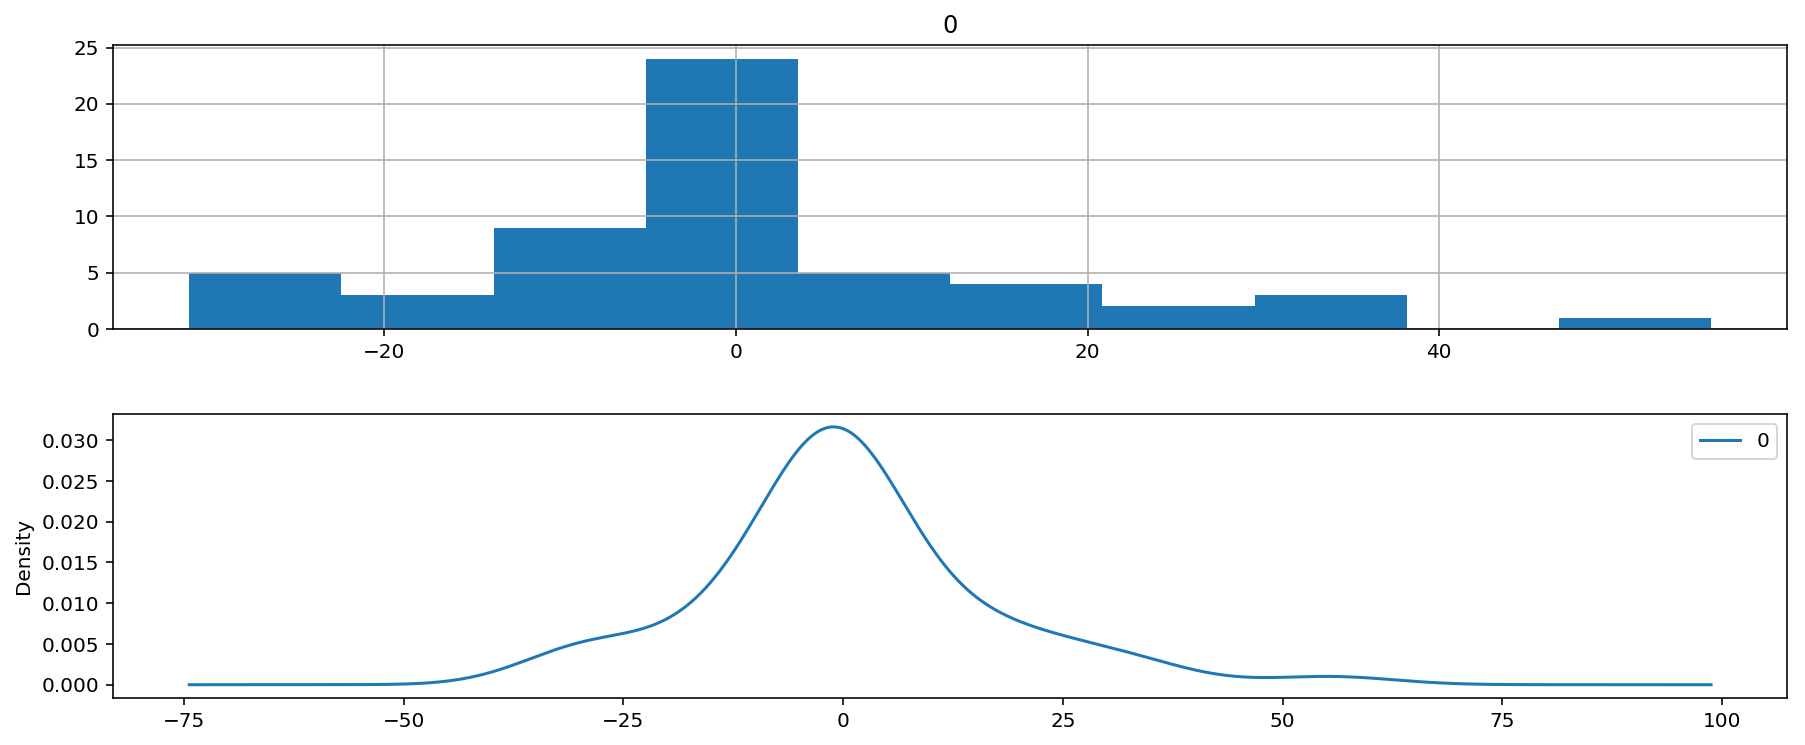

>Predicted=63.901, Expected= 36
>Predicted=100.809, Expected=134
>Predicted=60.748, Expected= 22
>Predicted=20.925, Expected= 20
>Predicted=26.377, Expected= 30
>Predicted=30.830, Expected= 32
>Predicted=30.813, Expected= 30
>Predicted=42.097, Expected= 48
>Predicted=49.098, Expected= 50
>Predicted=94.100, Expected=117
>Predicted=95.878, Expected= 85
>Predicted=35.527, Expected= 10
RMSE: 19.856


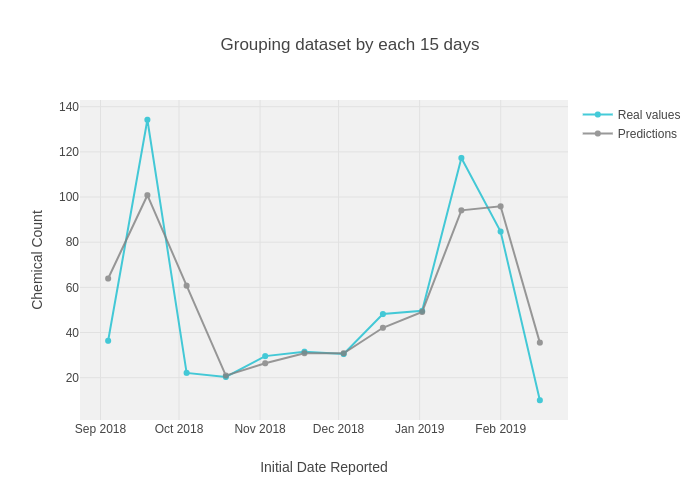

In [21]:
# Set the datasets with the dataset_limit
dataset = data[data.index < dataset_limit]
validation = data[data.index >= dataset_limit]

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

dataset = dataset.resample('15D').mean().dropna()
validation = validation.resample('15D').mean().dropna()

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

img = all_process(dataset, validation, 'Grouping dataset by each 15 days', 'ts-grouping-by-15days')
Image(img)

---

### 5.2. Grouping dataset by each 7 days

Len(dataset) = 1749
Len(validation) = 114
Len(dataset) = 467
Len(validation) = 25
ARIMA(0, 0, 1) RMSE=50.716
ARIMA(0, 0, 2) RMSE=36.891
ARIMA(0, 1, 1) RMSE=30.952
ARIMA(0, 1, 2) RMSE=36.592
ARIMA(0, 1, 3) RMSE=29.108
ARIMA(1, 0, 0) RMSE=29.512
ARIMA(1, 0, 1) RMSE=27.441
ARIMA(1, 0, 2) RMSE=29.347
ARIMA(1, 0, 3) RMSE=29.289
ARIMA(1, 1, 0) RMSE=15.064
ARIMA(1, 1, 2) RMSE=27.178
ARIMA(2, 0, 0) RMSE=28.272
ARIMA(2, 0, 1) RMSE=26.222
ARIMA(2, 0, 2) RMSE=27.341
ARIMA(2, 1, 0) RMSE=24.351
ARIMA(2, 1, 2) RMSE=27.448
ARIMA(3, 0, 0) RMSE=29.170
ARIMA(3, 0, 1) RMSE=27.657
ARIMA(3, 0, 3) RMSE=28.511
ARIMA(3, 1, 0) RMSE=21.829
ARIMA(3, 1, 2) RMSE=27.648
Best ARIMA(1, 1, 0) RMSE=15.064
                0
count  117.000000
mean    -0.209305
std     15.127304
min    -89.528719
25%     -1.901716
50%      0.115341
75%      2.696821
max     57.290556


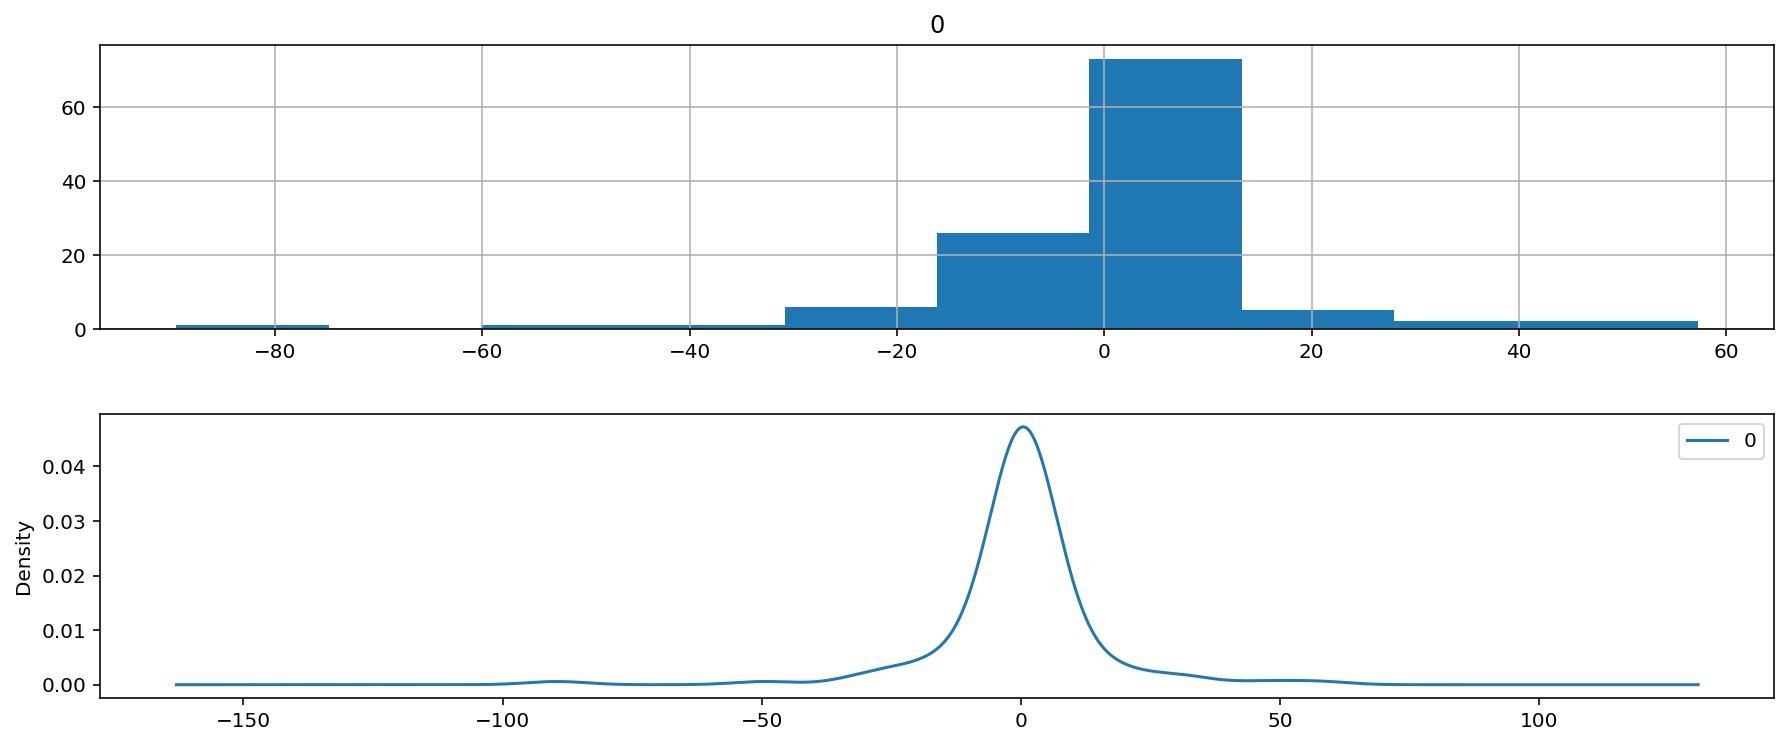

>Predicted=50.848, Expected= 34
>Predicted=42.847, Expected= 45
>Predicted=228.475, Expected=274
>Predicted=73.754, Expected= 21
>Predicted=26.512, Expected= 28
>Predicted=18.745, Expected= 16
>Predicted=29.079, Expected= 32
>Predicted=11.063, Expected=  6
>Predicted=16.684, Expected= 20
>Predicted=23.288, Expected= 24
>Predicted=35.553, Expected= 38
>Predicted=23.430, Expected= 20
>Predicted=38.137, Expected= 43
>Predicted=35.070, Expected= 33
>Predicted=24.594, Expected= 22
>Predicted=42.067, Expected= 47
>Predicted=54.311, Expected= 56
>Predicted=63.172, Expected= 65
>Predicted=38.988, Expected= 32
>Predicted=41.399, Expected= 44
>Predicted=174.081, Expected=208
>Predicted=91.477, Expected= 60
>Predicted=111.331, Expected=125
>Predicted=50.470, Expected= 30
>Predicted=14.309, Expected= 10
RMSE: 17.986


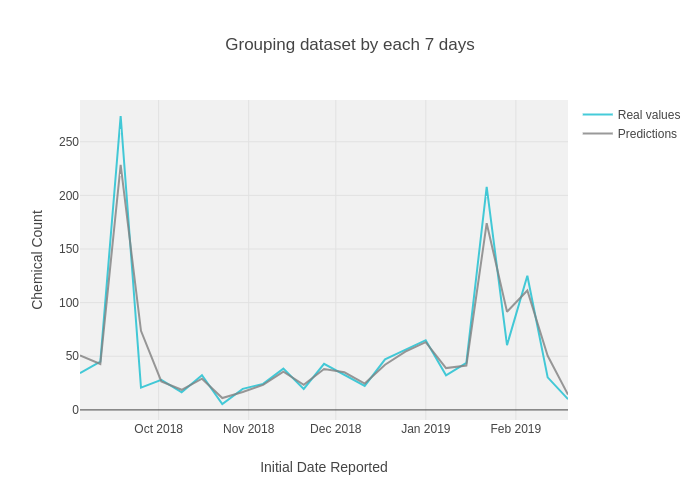

In [22]:
# Set the datasets with the dataset_limit
dataset = data[data.index < dataset_limit]
validation = data[data.index >= dataset_limit]

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

dataset = dataset.resample('7D').mean().dropna()
validation = validation.resample('7D').mean().dropna()

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

img = all_process(dataset, validation, 'Grouping dataset by each 7 days', 'ts-grouping-by-7days')
Image(img)

---

### 5.3. All dataset

Len(dataset) = 1749
Len(validation) = 114
ARIMA(0, 0, 1) RMSE=69.175
ARIMA(0, 0, 2) RMSE=48.260
ARIMA(0, 1, 1) RMSE=29.268
ARIMA(0, 1, 2) RMSE=43.112
ARIMA(0, 1, 3) RMSE=33.660
ARIMA(1, 0, 0) RMSE=31.730
ARIMA(1, 0, 1) RMSE=29.236
ARIMA(1, 0, 2) RMSE=42.086
ARIMA(1, 0, 3) RMSE=33.943
ARIMA(1, 1, 0) RMSE=12.905
ARIMA(1, 1, 1) RMSE=34.177
ARIMA(1, 1, 2) RMSE=31.738
ARIMA(1, 1, 3) RMSE=36.367
ARIMA(2, 0, 0) RMSE=29.333
ARIMA(2, 0, 1) RMSE=37.314
ARIMA(2, 0, 2) RMSE=34.927
ARIMA(2, 0, 3) RMSE=39.274
ARIMA(2, 1, 0) RMSE=25.572
ARIMA(2, 1, 1) RMSE=34.278
ARIMA(2, 1, 2) RMSE=38.580
ARIMA(2, 1, 3) RMSE=39.141
ARIMA(3, 0, 0) RMSE=31.584
ARIMA(3, 0, 1) RMSE=37.193
ARIMA(3, 0, 2) RMSE=41.925
ARIMA(3, 0, 3) RMSE=41.829
ARIMA(3, 1, 0) RMSE=38.355
ARIMA(3, 1, 1) RMSE=38.149
ARIMA(3, 1, 2) RMSE=39.087
ARIMA(3, 1, 3) RMSE=40.530
Best ARIMA(1, 1, 0) RMSE=12.905
                0
count  438.000000
mean    -0.142791
std     12.919148
min   -117.351816
25%     -0.900469
50%      0.000000
75%      0.869375

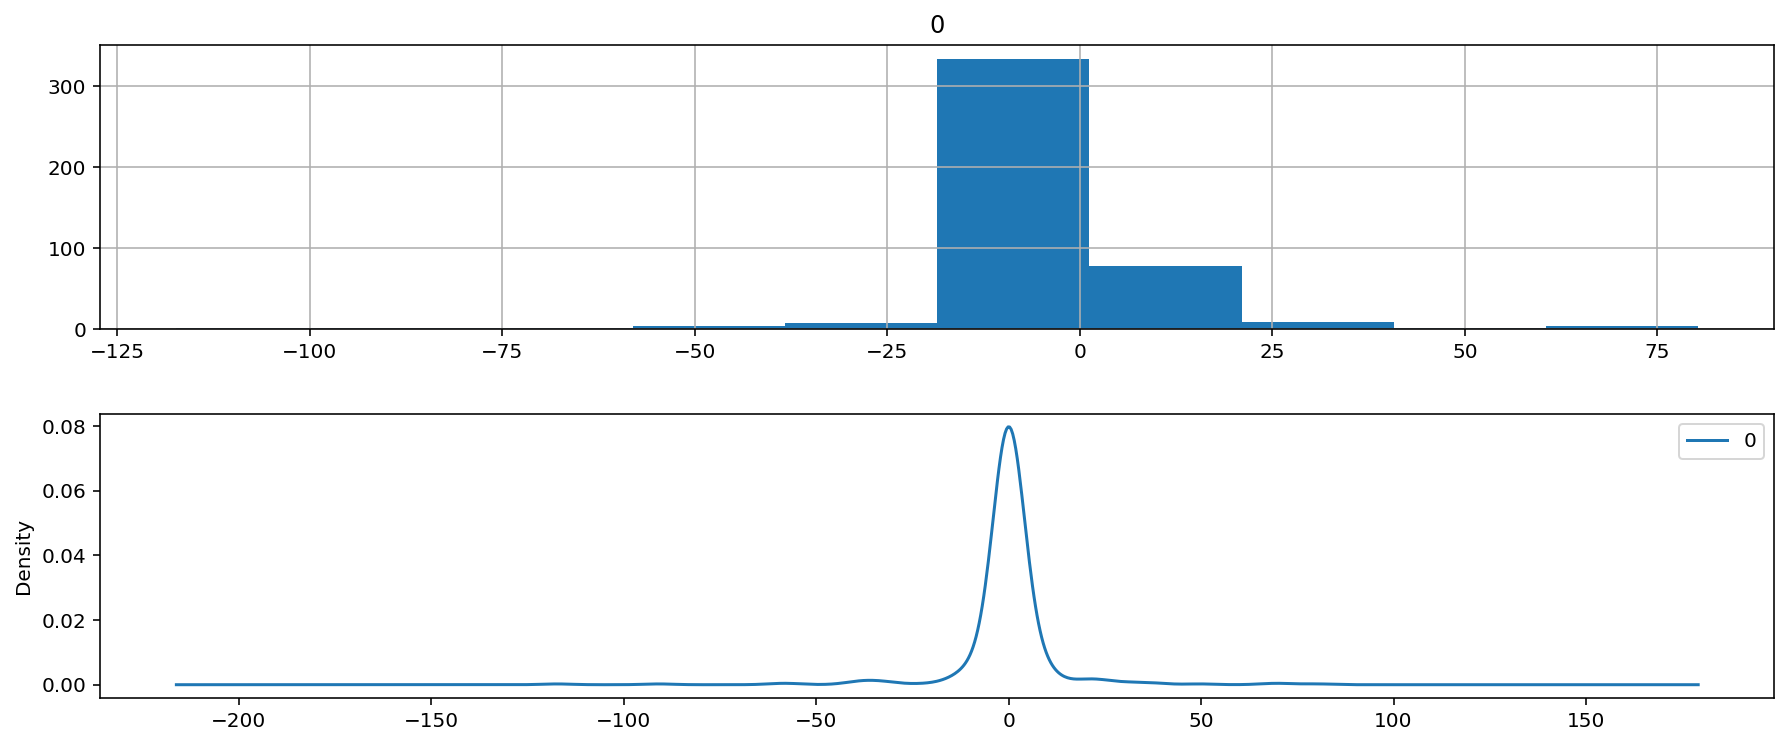

>Predicted=33.283, Expected= 16
>Predicted=3.024, Expected=  1
>Predicted=8.786, Expected= 10
>Predicted=103.433, Expected=118
>Predicted=38.432, Expected= 26
>Predicted=46.756, Expected= 50
>Predicted=68.162, Expected= 71
>Predicted=21.705, Expected= 14
>Predicted=20.054, Expected= 21
>Predicted=93.647, Expected=105
>Predicted=854.113, Expected=969
>Predicted=150.427, Expected=  1
>Predicted=6.097, Expected=  7
>Predicted=2.752, Expected=  2
>Predicted=1.150, Expected=  1
>Predicted=41.779, Expected= 49
>Predicted=45.602, Expected= 45
>Predicted=31.407, Expected= 29
>Predicted=28.150, Expected= 28
>Predicted=50.089, Expected= 54
>Predicted=8.975, Expected=  1
>Predicted=4.398, Expected=  5
>Predicted=12.646, Expected= 14
>Predicted=27.593, Expected= 30
>Predicted=18.107, Expected= 16
>Predicted=27.044, Expected= 29
>Predicted=13.709, Expected= 11
>Predicted=3.354, Expected=  2
>Predicted=88.649, Expected=104
>Predicted=18.225, Expected=  3
>Predicted=3.849, Expected=  4
>Predicted=8.2

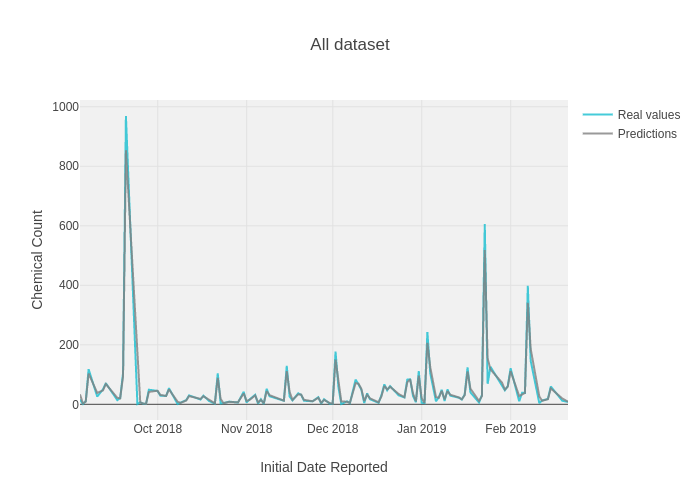

In [23]:
# Set the datasets with the dataset_limit
dataset = data[data.index < dataset_limit]
validation = data[data.index >= dataset_limit]

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

img = all_process(dataset, validation, 'All dataset', 'ts-alldataset')
Image(img)

---

## 6. Final Models 

### 6.1. Grouping by months

In [24]:
# Set the datasets with the dataset_limit
dataset = data[data.index < dataset_limit]
validation = data[data.index >= dataset_limit]

# Grouping by month
dataset = dataset.resample('MS').mean().dropna()
validation = validation.resample('MS').mean().dropna()

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

best_cfg = (1, 1, 0)

model = ARIMA(dataset, order=best_cfg)
model_fit = model.fit(trend='nc', disp=0)

Len(dataset) = 110
Len(validation) = 6


### 6.2. Grouping by each 15 days

In [25]:
# Set the datasets with the dataset_limit
dataset = data[data.index < dataset_limit]
validation = data[data.index >= dataset_limit]

# Grouping by each 15 days
dataset = dataset.resample('15D').mean().dropna()
validation = validation.resample('15D').mean().dropna()

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

best_cfg = (1, 1, 0)

model = ARIMA(dataset, order=best_cfg)
model_fit = model.fit(trend='nc', disp=0)

Len(dataset) = 223
Len(validation) = 12


### 6.3. Grouping by each 7 days

In [26]:
# Set the datasets with the dataset_limit
dataset = data[data.index < dataset_limit]
validation = data[data.index >= dataset_limit]

# Grouping by each 7 days
dataset = dataset.resample('7D').mean().dropna()
validation = validation.resample('7D').mean().dropna()

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

best_cfg = (1, 1, 0)

model = ARIMA(dataset, order=best_cfg)
model_fit = model.fit(trend='nc', disp=0)

Len(dataset) = 467
Len(validation) = 25


### 6.4. All dataset

In [27]:
# Set the datasets with the dataset_limit
dataset = data[data.index < dataset_limit]
validation = data[data.index >= dataset_limit]

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

best_cfg = (1, 1, 0)

model = ARIMA(dataset, order=best_cfg)
model_fit = model.fit(trend='nc', disp=0)

Len(dataset) = 1749
Len(validation) = 114


---

## 7. Conclusions and Model's Selection

We have four models with the following results:

| Model       | Dataset's size | Dataset's RMSE | Validation's size | Validation's RMSE | 
|-------------|----------------|----------------|-------------------|-------------------|
| by months   |  110           |  18.822        |  6                |  15.212           |
| by each 15 days  |  223           |  15.903        |  12               |  19.856          |
| by each 7 days   |  467           |  15.064        |  25               |  17.986           |
| all dataset |  1749          |  12.905       |  114              |  23.571          |

As we can see, the RMSE does not increase according to dataset's size in all cases. Let's know in what cases and in what proportion the RMSE increase using the following formula:

$$prop(x,y) = \frac{x-y}{x} * 100$$

In [29]:
def get_proportion(x, y) :
    return (x-y)/x*100

print("Dataset's proportion\n----------------")
print()
print('month - 15d | Size: %.3f' % get_proportion(223, 110), "%")
print('month - 15d | RMSE: %.3f' % get_proportion(15.903, 18.822), "%")
print()
print('15d - 7d | Size: %.3f' % get_proportion(467, 223), "%")
print('15d - 7d | RMSE: %.3f' % get_proportion(15.064, 15.903), "%")
print()
print('7d - all | Size: %.3f' % get_proportion(1749, 467), "%")
print('7d - all | RMSE: %.3f' % get_proportion(12.905, 15.064), "%")

print()
print()

print("Validation's proportion\n----------------")
print()
print('month - 15d | Size: %.3f' % get_proportion(12, 6), "%")
print('month - 15d | RMSE: %.3f' % get_proportion(19.856, 15.212), "%")
print()
print('15d - 7d | Size: %.3f' % get_proportion(25, 12), "%")
print('15d - 7d | RMSE: %.3f' % get_proportion(17.986, 19.856), "%")
print()
print('7d - all | Size: %.3f' % get_proportion(114, 25), "%")
print('7d - all | RMSE: %.3f' % get_proportion(23.571, 17.986), "%")

Dataset's proportion
----------------

month - 15d | Size: 50.673 %
month - 15d | RMSE: -18.355 %

15d - 7d | Size: 52.248 %
15d - 7d | RMSE: -5.570 %

7d - all | Size: 73.299 %
7d - all | RMSE: -16.730 %


Validation's proportion
----------------

month - 15d | Size: 50.000 %
month - 15d | RMSE: 23.388 %

15d - 7d | Size: 52.000 %
15d - 7d | RMSE: -10.397 %

7d - all | Size: 78.070 %
7d - all | RMSE: 23.694 %


Now, we know that according to dataset's size the RMSE always decreases, although between `by each 15 days` and `by each 7 days` its decrease is lesser.

According to validation's size:

- Between `by month` and `by each 15 days` datasets and `by each 7 days` and `all dataset` datasets, the RMSE increases (almost) in the same proportion between datasets regardless its size.
- Between `by each 15 days` and `by each 7 days` datasets, the RMSE decreases. 

With that, we can say that the best model is `all dataset`, because it has a low RMSE according to the data's size. However, for that use case, we do not need the forecast of each day because it is not relevant the amount of chemical in a day if not the accumulated amount of chemicals in a months or each X days. In addition, that model is very complex and its fitting is very slow.

The `by each 7 days` model gives very good results and with a low RMSE too, so we are going to select this model as final model.

---